In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import math as m
import vice
import sys
load_style_sheet("papers")
print(sys.version_info)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
output = vice.output("../outputs/constant/vgas-1")

In [3]:
def get_velocity_profile(output, lookback):
    raw = np.genfromtxt("%s_gasvelocities.out" % (output.name))
    time = output.zones["zone0"].history["time"][-1] - lookback
    diff = [abs(_ - time) for _ in output.zones["zone0"].history["time"]]
    idx = diff.index(min(diff))
    time = output.zones["zone0"].history["time"][idx]
    # print(time)
    radii = []
    vgas = []
    for i in range(len(raw)):
        if raw[i][0] == time:
            radii.append(raw[i][1])
            vgas.append(raw[i][2])
        else: pass
    return [radii, vgas]

def mu(output, lookback, zone_width = 0.1):
    radii, vgas = get_velocity_profile(output, lookback)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    mu_gas = []
    mu_oxygen = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        neighbor = output.zones["zone%d" % (i + 1)]
        if radii[i + 1] >= 15.5:
            mu_gas.append(float("nan"))
            mu_oxygen.append(float("nan"))
        else:
            tau_star = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            mu = (neighbor.history["mgas"][idx] - zone.history["mgas"][idx]) / (zone.history["mgas"][idx] * zone_width)
            mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
            mu *= -tau_star * vgas[i]
            mu_gas.append(mu)
            mu -= tau_star * vgas[i] * (
                neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]) / (zone.history["z(o)"][idx] * zone_width)
            mu_oxygen.append(mu)
    return [radii, mu_gas, mu_oxygen]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_20245/2750616491.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


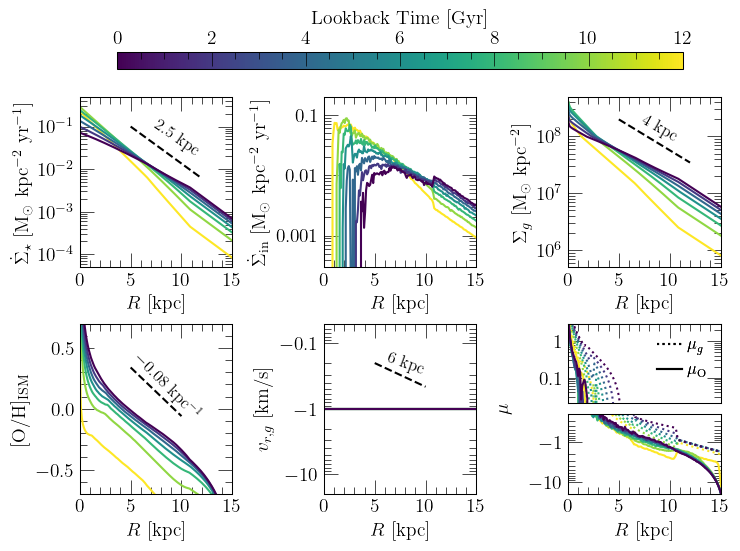

In [4]:
LOOKBACKS = [12, 10, 8, 6, 4, 2, 0]
# COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet", "black"]
COLORMAP = "viridis"
XLIM = 6 * [[0, 15]]
YLIM = [[5.e-5, 0.5], [3.e-4, 0.2], [5.e5, 5.e8], [-0.7, 0.7], [0.05, 20], [0.02, 3], [0.2, 20]]

fig = plt.figure(figsize = (7.5, 5.6))
axes = 6 * [None]
for i in range(6):
    axes[i] = fig.add_subplot(231 + i)
    if i != 5: axes[i].set_xlabel(r"$R$ [kpc]", fontsize = 14)
    if i < 3: axes[i].set_yscale("log")
    axes[i].set_xlim(XLIM[i])
    axes[i].set_xticks([0, 5, 10, 15])
    axes[i].set_ylim(YLIM[i])
axes[-1].set_yscale("log")
axes[-1].yaxis.set_major_formatter(fsf("%g"))
axes[1].yaxis.set_major_formatter(fsf("%g"))
axes[0].set_ylabel(r"$\dot\Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]", fontsize = 14)
axes[1].set_ylabel(r"$\dot\Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]", fontsize = 14)
axes[2].set_ylabel(r"$\Sigma_g$ [M$_\odot$ kpc$^{-2}$]", fontsize = 14)
axes[3].set_ylabel(r"[O/H]$_\text{ISM}$")
axes[4].set_ylabel(r"$v_{r,g}$ [km/s]")

bottom = fig.add_axes([0.8, 0.8, 0.1, 0.1], sharex = axes[-1])
plt.setp(axes[-1].get_xticklabels(), visible = False)
bottom.set_xlabel(r"$R$ [kpc]")
bottom.set_ylim(YLIM[-1])
dummy = fig.add_axes([0.8, 0.8, 0.1, 0.1], xticks = [], yticks = [], zorder = -1000)
dummy.spines["left"].set_visible(False)
dummy.spines["right"].set_visible(False)
dummy.set_ylabel(r"$\mu$", labelpad = 40)
axes[-1].tick_params(axis = "x", which = "both", bottom = False)
bottom.tick_params(axis = "x", which = "both", top = False)

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)

def plot_snapshot(output, lookback, zone_width = 0.1, **kwargs):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    sigma_sfr = []
    sigma_in = []
    sigma_gas = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width / 2)**2 - (radii[i] - zone_width / 2)**2)
        zone = output.zones["zone%d" % (i)]
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_in.append(zone.history["ifr"][idx] / area)
        sigma_gas.append(zone.history["mgas"][idx] / area)
    axes[0].plot(radii, sigma_sfr, **kwargs)
    axes[1].plot(radii, sigma_in, **kwargs)
    axes[2].plot(radii, sigma_gas, **kwargs)

    radii, vgas = get_velocity_profile(output, lookback)
    _, mu_gas, mu_oxygen = mu(output, lookback)
    oh_ism = []
    for i in range(len(radii)):
        oh_ism.append(output.zones["zone%d" % (i)].history["[o/h]"][idx])
    axes[3].plot(radii, oh_ism, **kwargs)
    axes[4].plot(radii, [-v for v in vgas], **kwargs)
    axes[5].plot(radii[:-1], mu_oxygen, **kwargs)
    axes[5].plot(radii[:-1], mu_gas, linestyle = ":", **kwargs)
    bottom.plot(radii[:-1], [-mu for mu in mu_oxygen], **kwargs)
    bottom.plot(radii[:-1], [-mu for mu in mu_gas], linestyle = ":", **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i]),
        # "label": "%g Gyr ago" % (LOOKBACKS[i])
    }
    plot_snapshot(output, LOOKBACKS[i], **kwargs)

cbar_ax = fig.add_axes([0.2, 0.8, 0.6, 0.05])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal", location = "top")
cbar.set_label("Lookback Time [Gyr]")

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "--"
}
fs = 12
xvals = np.linspace(5, 12, 100)
yvals = [0.1 * np.exp(-(x - xvals[0]) / 2.5) for x in xvals]
axes[0].plot(xvals, yvals, **kwargs)
axes[0].text(7, 0.02, r"2.5 kpc", fontsize = fs, rotation = -35)

yvals = [2.e8 * np.exp(-(x - xvals[0]) / 4) for x in xvals]
axes[2].plot(xvals, yvals, **kwargs)
axes[2].text(7, 8e7, r"4 kpc", fontsize = fs, rotation = -30)

xvals = np.linspace(5, 10, 100)
yvals = [-0.08 * (x - 8) + 0.1 for x in xvals]
axes[3].plot(xvals, yvals, **kwargs)
axes[3].text(5, -0.1, r"$-0.08$ kpc$^{-1}$", fontsize = fs, rotation = -45)

yvals = [0.2 * np.exp((x - xvals[0]) / 6) for x in xvals]
axes[4].plot(xvals, yvals, **kwargs)
axes[4].text(6, 0.3, r"6 kpc", fontsize = fs, rotation = -20)

kwargs = {
    "c": named_colors()["black"]
}
lines = []
lines.append(axes[-1].plot([0, 1], [11, 12], linestyle = ":", label = r"$\mu_g$", **kwargs)[0])
lines.append(axes[-1].plot([0, 1], [11, 12], linestyle = "-", label = r"$\mu_\text{O}$", **kwargs)[0])
kwargs = {
    "loc": mpl_loc("upper right"),
    "fontsize": 12,
    "handlelength": 1.5,
    # "bbox_to_anchor": (1, 0)
}
leg = axes[-1].legend(**kwargs)
axes[-1].add_artist(leg)
lines[0].remove()
lines[1].remove()

plt.tight_layout()
axes[-2].yaxis.set_major_formatter(fsf("%g"))
bottom.yaxis.set_major_formatter(fsf("%g"))
negative_log(axes[-2])
negative_log(bottom)
plt.subplots_adjust(top = 0.82, wspace = 0.6)
mu_split = 0.01
cbar_ax.set_position([
    axes[0].get_position().x0 + 0.05,
    axes[0].get_position().y1 + 0.05,
    axes[2].get_position().x1 - axes[0].get_position().x0 - 0.1,
    0.03
])
axes[-1].set_position([
    axes[-1].get_position().x0,
    (axes[-2].get_position().y0 + axes[-2].get_position().y1) / 2 + mu_split,
    axes[-1].get_position().x1 - axes[-1].get_position().x0,
    (axes[-2].get_position().y1 - axes[-2].get_position().y0) / 2 - mu_split
])
bottom.set_position([
    axes[-1].get_position().x0,
    axes[-2].get_position().y0,
    axes[-1].get_position().x1 - axes[-1].get_position().x0,
    (axes[-2].get_position().y1 - axes[-2].get_position().y0) / 2 - mu_split
])
dummy.set_position([
    bottom.get_position().x0,
    bottom.get_position().y0,
    bottom.get_position().x1 - bottom.get_position().x0,
    axes[-1].get_position().y1 - bottom.get_position().y0
])
# for ext in ["pdf", "jpeg"]:
#     kwargs = {}
#     if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("./angular-momentum-dilution/angular-momentum-dilution.%s" % (ext), **kwargs)
plt.show()